In [97]:
%load_ext autoreload
%autoreload 2
from TPTBox import NII,to_nii
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from einops import rearrange
from omegaconf import OmegaConf
from notebook_helpers import load_model_from_config,visualize_cond_img,get_model
import numpy as np

In [98]:
t2w_path = "/media/data/robert/datasets/t2w_ct/registration/spinegan0152/target-301_from-201/sub-spinegan0152_ses-20220623_sequ-301_reg-201_e-1_dixon.nii.gz"

nii = to_nii(t2w_path)
nii.rescale_((1,1,1)).reorient_(('R', 'I', 'P'))

shp=(47, 279, 180); ori=('R', 'I', 'P'), zoom=(1.0, 1.0, 1.0), seg=False

In [99]:

path_conf = ("/media/data/robert/code/latent-diffusion/logs/2024-10-02T10-21-32_T2w_2_ct_32x32/T2w_2_ct_32x32.yaml")
config = OmegaConf.load(path_conf)
model_d, step = load_model_from_config(
    config,
    "/media/data/robert/code/latent-diffusion/logs/2024-10-02T10-21-32_T2w_2_ct_32x32/checkpoints/last.ckpt",
    )



Loading model from /media/data/robert/code/latent-diffusion/logs/2024-10-02T10-21-32_T2w_2_ct_32x32/checkpoints/last.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 131.15 M params.
Keeping EMAs of 522.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


####################################
/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/media/data/anaconda3/envs/ldm/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/media/data/anaconda3/envs/ld

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Reload AutoencoderKL:  logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt
Restored from logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Reload AutoencoderKL:  logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt
Restored from logs/2024-09-25T12-05-27_autoencoder_kl_32x32x4_gray/checkpoints/last.ckpt


In [100]:


def get_cond(lr_image_array, hr_image_array):
    example = {}
    # Visualize the condition image (if needed, you can re-implement this function as well)
    visualize_cond_img(lr_image_array,hr_image_array)

    # Process the Low Resolution (LR) image
    c = torch.unsqueeze(torchvision.transforms.ToTensor()(Image.fromarray(lr_image_array)), 0)
    #c = rearrange(c, "1 c h w -> 1 c")
    c = 2.0 * (c/c.max()) - 1.0  # Normalize image

    # Process the High Resolution (HR) image (this assumes the HR image is already provided)
    c_up = torch.unsqueeze(torchvision.transforms.ToTensor()(Image.fromarray(hr_image_array)), 0)
    #c_up = rearrange(c_up, "1 c h w -> 1 h w c")
    # Send to GPU
    c = c.to(torch.device("cuda"))
    c_up = c_up.to(torch.device("cuda"))

    example["c_concat"] = c
    #example["x"] = c_up

    return example
def visualize_cond_img(*image_array):
    i = np.concatenate([*image_array],-1)
    # Display the image array using matplotlib
    plt.imshow(i,cmap='gray')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

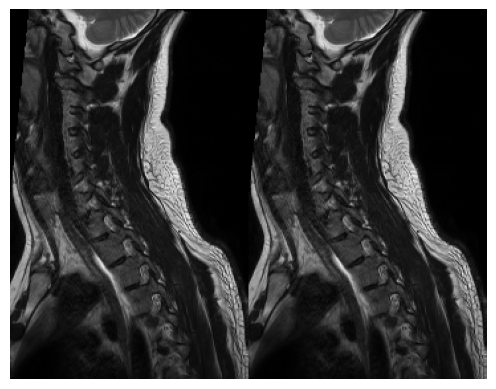

In [101]:
cond = get_cond(nii.get_array()[10],nii.get_array()[10])

In [102]:
cond[next(iter(cond.keys()))].shape

torch.Size([1, 1, 279, 180])

In [120]:
from ldm.models.diffusion.ddim import DDIMSampler
@torch.no_grad()
def convsample_ddim(
    model,
    cond,
    steps,
    eta=1.0,
    callback=None,
    normals_sequence=None,
    mask=None,
    x0=None,
    quantize_x0=False,
    temperature=1.0,
    score_corrector=None,
    corrector_kwargs=None,
    x_T=None
):
    img = cond["c_concat"]
    encoder_posterior = model.encode_first_stage(img)
    c = model.get_first_stage_encoding(encoder_posterior).detach()
    #c = rearrange(c, "1 c h w -> 1 h w c")
    cond2 = {"c_concat": [c]}
    print(cond["c_concat"].shape)
    print(c.shape)    
    shape = c.shape
    ddim = DDIMSampler(model)
    bs = shape[0]  # dont know where this comes from but wayne
    shape = shape[1:]  # cut batch dim
    print(f"Sampling with eta = {eta}; steps: {steps}")
    samples, intermediates = ddim.sample(
        steps,
        batch_size=bs,
        shape=shape,
        conditioning=cond2,
        callback=callback,
        normals_sequence=normals_sequence,
        quantize_x0=quantize_x0,
        eta=eta,
        mask=mask,
        x0=x0,
        temperature=temperature,
        verbose=False,
        score_corrector=score_corrector,
        corrector_kwargs=corrector_kwargs,
        x_T=x_T
    )

    return samples, intermediates

log =convsample_ddim(model_d["model"],cond,20)

torch.Size([1, 1, 279, 180])
torch.Size([1, 4, 34, 22])
Sampling with eta = 1.0; steps: 20
Data shape for DDIM sampling is (1, 4, 34, 22), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler:   0%|          | 0/20 [00:00<?, ?it/s]

openaimodel.UNetModel torch.Size([1, 8, 34, 22]) torch.Size([1]) None
openaimodel.UNetModel.timestep_embedding torch.Size([1]) 128
openaimodel.UNetModel.input_blocks torch.Size([1, 8, 34, 22]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 128, 34, 22]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 128, 34, 22]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 128, 34, 22]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 128, 17, 11]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 256, 17, 11]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 256, 17, 11]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 256, 8, 5]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 256, 8, 5]) torch.Size([1, 512]) None
openaimodel.UNetModel.input_blocks torch.Size([1, 256, 8, 5]) tor

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4 but got size 5 for tensor number 1 in the list.